## Scenario6 - Study Optimal drone count

In [25]:
from scipy.optimize import least_squares
import numpy as np
import time
from pandas import DataFrame
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import sem
from sklearn import  linear_model
import ast
from scipy.optimize import curve_fit
import time
import random

# Util methods

### Method to generate drone position required for simulation

In [5]:
def fun_generate_drone_pos(drone_count):
    lpos = []
    for i in range(drone_count):
        xy=np.random.uniform(-10,10,2)
        x=xy[0]
        y=xy[1]
        z=np.random.uniform(2,7,1)[0]
        lpos.append(x)
        lpos.append(y)
        lpos.append(z)
    return (np.asarray(lpos).reshape(1,drone_count, 3))

### Calculate the time-of-flight data with the actual drone position and ground object location

In [7]:
def calc_timelags_noisedp(n, dp_orig, dp_noise):
    json_loc = {}
    list_orig_y = []
    json1 = {}
    for i in range(n):
        for k in range(i, n):
            outer = i + 1
            inner = k + 1
            key = "" + str(outer) +"_"+ str(inner)

            if(i==k):
                val=  math.sqrt(sum((x_original-dp_orig[0][i])**2)) * 2 
                pos1 = dp_noise[0][i]
                pos2 = ""
                #print(key, " ", val)
            else: 
                #print(key , ",", "i = ", i, "k=", k)
                val = math.sqrt(sum((x_original-dp_orig[0][outer-1])**2)) + math.sqrt(sum((x_original-dp_orig[0][inner-1])**2))
                pos1 = dp_noise[0][outer-1]
                pos2 = dp_noise[0][inner-1]
                #print(key, " ", val)
            
            json11 = {key: val, "pos1":pos1, "pos2":pos2 }
            json1.update(json11)
            list_orig_y.append(json11)
            #json.append(json1)

    #print(json1)
    return list_orig_y

### Calculate the difference bw actual and recovered object location

In [8]:
def calc_recored_go_pos_err(actual_go,recovered_go):
    sq_diff=((actual_go-recovered_go)**2)
    total_sum_go_err = np.sqrt(  sq_diff[0]) + np.sqrt( sq_diff[1]) + np.sqrt( sq_diff[2])
    return total_sum_go_err

### Objective function to recover the object location - the function takes input as initial guess of object location, drone coordinates, time-of-flight and LS method iteratively calls this function to minimize

In [9]:

def recover_GO_pos(x ):
    x[2]=0
    list_orig_y = list_temp_json[0]
    listval =[]

    for json_y in list_orig_y:
        c = 0
        for key in json_y:
            # execute the logic only once per json obj(there are 3 keys), c=0 controls this logic
            if(c==0):
                #print("json--", json_y)
                #print("key--",key)
                v = json_y[key]
                #print("v===",v)
                k = key.split("_")
                k1 = k[0]
                k2 = k[1]
                
                k1=k1.strip()
                k1=int(k1)
                
                k2=k2.strip()
                k2=int(k2)

                if(k1==k2):
                    val=  v - math.sqrt(sum((x-json_y["pos1"])**2))* 2
                    listval.append(val)
                else:
                    val = v - (math.sqrt(sum((x-json_y["pos1"])**2)) + math.sqrt(sum((x-json_y["pos2"])**2)))
                    listval.append(val)
                    
            c = 1
    #print("listval---",listval)
    an_array = np.array(listval)
    an_array1 = an_array**2
    loss = sum(an_array1)
    #print(loss)
    #print("loss---",loss)
    return np.array(loss)

### Function to add noise to drone position

In [10]:
def addnoise_to_drone_pos(dp_orig, sd):
    noise = np.random.normal(0, sd, dp_orig.shape)
    dp_noise = dp_orig + noise
    return dp_noise

### Variable initilization

In [12]:
x_original=np.array([2.8,2.2,0])
xy_initial = np.array([0,0,0]) 

# Invoke LS with different drone count for noise level 0.5

In [19]:
start_time = time.time()
list_temp_json = []
df_results = DataFrame(columns=[ 'uncer_rec_go', 'std_err_rec_go_pos', 'drone_count'])
ite = 0
noise_sd=0.5
listdronecount = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for drone_count in listdronecount:
    list_goerror = []
    ite +=1
    for iterations in range(300):
        list_temp_json.clear()
        dp_real = fun_generate_drone_pos(drone_count)
        dp_noise = addnoise_to_drone_pos(dp_real,sd=noise_sd)
        list_orig_y = calc_timelags_noisedp(drone_count,dp_real, dp_noise)
        list_temp_json.insert(0, list_orig_y)

        result = least_squares(recover_GO_pos, xy_initial)
        err_go = calc_recored_go_pos_err(x_original,result.x)

        list_goerror.append(err_go)
        
    avg_err_go = np.mean(list_goerror)
    sd_rec_calc_gopos = np.std(list_goerror) # sd of rec go obj pos
    std_err_calc_gopos = sem(list_goerror)   # std dev of rec go obj pos = sd/sqrt(n-1)
    df_results.loc[ite-1] = [ avg_err_go,std_err_calc_gopos,drone_count]

print("--- %s seconds ---" % (time.time() - start_time))      
df_results

--- 357.70087814331055 seconds ---


,uncer_rec_go,std_err_rec_go_pos,drone_count
0,1.226352,0.081570,3.0
1,0.914153,0.047996,4.0
2,0.710167,0.027743,5.0
3,0.608444,0.019691,6.0
4,0.590317,0.019270,7.0
5,0.556769,0.017550,8.0
6,0.481644,0.016531,9.0
7,0.471241,0.015413,10.0
8,0.450300,0.015695,11.0
9,0.420966,0.013476,12.0


### Define Power Law function - for curve fitting

In [86]:
def func_powerlaw(x, b, m):
    #print("b=",b, "------", "m=",m)
    val = m * x**b 
    return  val

### Fit a curve using SciPy's curve_fit method , Plot the curve

popt--- [-0.70710602  2.41454172]


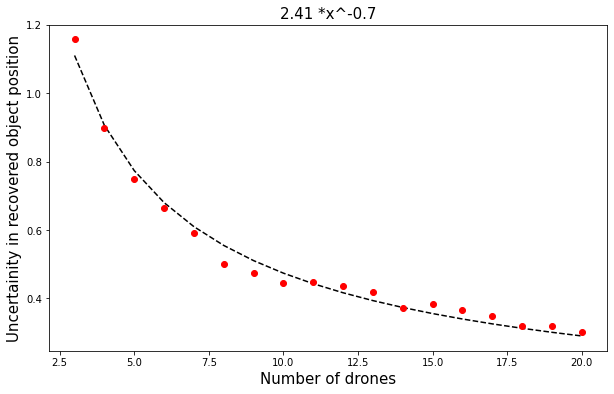

In [125]:
#x = df_final[["dronecount"]]
x=df_results.iloc[:,2].values
#y = df_final[["uncer_rec_go"]]
y=df_results.iloc[:,0].values
popt, pcov  = curve_fit(func_powerlaw, x, y, maxfev=2000 )
print("popt---",popt)
plt.figure(figsize=(10, 6))
b = popt[0]
m = popt[1]
plt.plot(x, func_powerlaw(x, *popt), '--', color='black')
plt.plot(x, y, 'ro')

#plt.loglog(x, func_powerlaw(x, *popt1), '--', color='blue')
#plt.loglog(x, y, 'ro')
plt.xlabel("Number of drones",fontdict={'fontsize':15})
plt.ylabel("Uncertainity in recovered object position",fontdict={'fontsize':15})
plt.title("2.41 *x^-0.7",fontdict={'fontsize':15})
plt.show()

### Log Log plot of drone count vs Uncertainty

Text(0.5, 1.0, 'Log Log Plot')

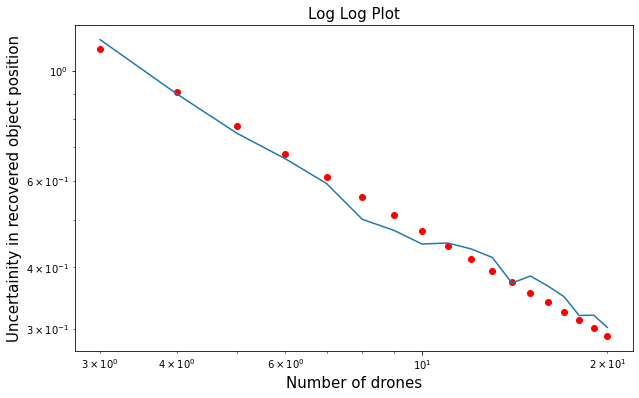

In [126]:
logy = func_powerlaw(x, b=-0.70710602, m=2.41454172)
plt.figure(figsize=(10, 6))
plt.loglog(x, y)
plt.scatter(x, logy,color="red")
plt.xlabel("Number of drones",fontdict={'fontsize':15})
plt.ylabel("Uncertainity in recovered object position",fontdict={'fontsize':15})
plt.title("Log Log Plot",fontdict={'fontsize':15})

# Invalid Code

c-- [-2.25690316         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan]
y-- [1.15715449 0.8979621  0.74842083 0.66381149 0.59148508 0.50055
 0.47562891 0.44616076 0.44833351 0.43631795 0.41925125 0.37192556
 0.38435699 0.3669924  0.34918969 0.31966962 0.32018894 0.30237214]
coeff-- [-0.66166789  0.34137526]


<ipython-input-100-0ba9ba26fbaf>:15: RuntimeWarning: invalid value encountered in log
  print("c--",np.log(c))


Text(0, 0.5, 'Uncertainity in recovered object position')

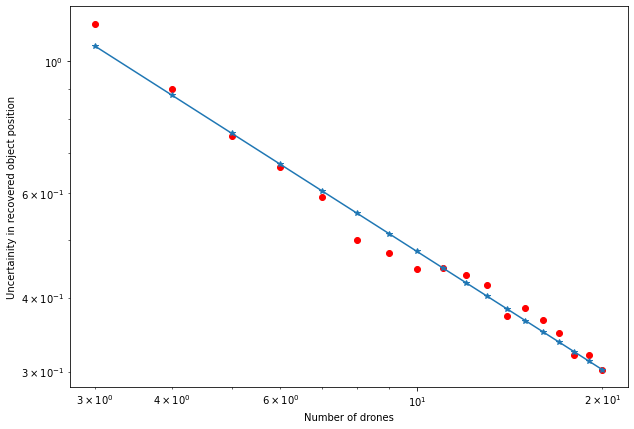

In [100]:
# Linear power law
def func_powerlaw_linear(x, b, m):
    k=b * np.log(x) + np.log(m)
    return k 

plt.figure(figsize=(10, 7))
x=df_results.iloc[:,2].values
y=df_results.iloc[:,0].values

coefficients = np.polyfit(np.log10(x), np.log10(y), 1)
b=-0.70710602
m=2.41454172

c = func_powerlaw_linear(x, b ,m )
print("c--",np.log(c))
print("y--",(y))
print("coeff--",coefficients)
polynomial = np.poly1d(coefficients)
log10_y_fit = polynomial(np.log10(x))  # <-- Changed

plt.scatter(x, y,color="red")
#plt.plot(x, 10**log10_y_fit, '*-')     # <-- Changed
plt.plot(x, 10**log10_y_fit, '*-')  
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Number of drones")
plt.ylabel("Uncertainity in recovered object position")

In [34]:
import powerlaw

In [65]:

fit = powerlaw.Fit(df_results.iloc[:,0].values)
print(fit.power_law.alpha)
print(fit.power_law.sigma)
fit.distribution_compare('power_law', 'exponential')

Calculating best minimal value for power law fit
3.714924246628152
0.7255940258519931


(0.1791859451111325, 0.8379674198188942)

In [36]:
# from networkx.utils import powerlaw_sequence
# pl_sequence = powerlaw_sequence(1000,exponent=2.5)
# fitted_pl = powerlaw.Fit(pl_sequence)

# fitted_pl.alpha

In [70]:
pl_sequence = powerlaw_sequence(20,exponent=3.373078223462273)
pl_sequence
fitted_pl = powerlaw.Fit(pl_sequence)
fitted_pl.alpha

Calculating best minimal value for power law fit


4.96384551633064

In [83]:
pl_sequence

[1.212518100608334,
 1.07602196477784,
 2.053358587827593,
 1.7569311722241934,
 1.1946218849647716,
 1.103349474918328,
 1.6901352851350246,
 1.0152032389251129,
 1.4647224199445306,
 1.1416286661997301,
 1.004583770895459,
 1.8363039330650388,
 1.1443367164812273,
 1.1014629567560272,
 1.0895878915338884,
 1.3002158697851995,
 1.3340252323560247,
 1.7847367385672857,
 1.0574110774658596,
 1.1530823523669531]

In [66]:
df_results.iloc[:,0].values

array([1.15715449, 0.8979621 , 0.74842083, 0.66381149, 0.59148508,
       0.50055   , 0.47562891, 0.44616076, 0.44833351, 0.43631795,
       0.41925125, 0.37192556, 0.38435699, 0.3669924 , 0.34918969,
       0.31966962, 0.32018894, 0.30237214])

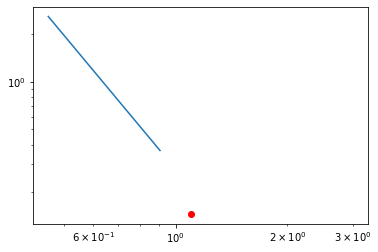

In [69]:
powerlaw.plot_pdf(df_results.iloc[:,0].values)
plt.scatter(np.log(x), np.log(y),color="red")